# First Intention Step Analysis - Revised with Proper Player Index Handling

This notebook analyzes first intention steps across different experimental conditions with proper handling of player indices:

**1P2G**: Individual human player's first intention step
**2P3G**: Human player's first intention step in collaborative settings, accounting for player index in human-gpt games

Analysis compares human-human vs human-gpt game types with correct player assignment handling.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Set color palette
colors = {'human-human': 'lightblue', 'human-gpt': 'lightcoral'}
sns.set_palette([colors['human-human'], colors['human-gpt']])


In [9]:
# Load and prepare data
data_dir = Path.cwd().parent / 'data'
excel_files = [f for f in data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

def load_and_process_file(file_path):
    """Load Excel file and add metadata"""
    try:
        df = pd.read_excel(file_path)
        participant_id = file_path.name.split('_')[2]
        df = df.assign(participantID=participant_id, file_id=file_path.name)
        return df
    except Exception as e:
        print(f"Error loading {file_path.name}: {e}")
        return None

# Load all files
all_data = []
for file_path in excel_files:
    df_part = load_and_process_file(file_path)
    if df_part is not None:
        all_data.append(df_part)

# Combine all data
df = pd.concat(all_data, ignore_index=True)

# Load game classification
try:
    class_map = pd.read_csv(data_dir / 'game_classification_results.csv')[['file_id','game_class']]
    df = df.merge(class_map, on='file_id', how='left', suffixes=('', '_from_class_map'))
    print("Merged game classification using file_id")
except Exception as e:
    print('Failed to load game classification:', e)
    df['game_class'] = 'unknown'

# Filter to focus only on human-human and human-gpt game types
df_focused = df[df['game_class'].isin(['human-human', 'human-gpt'])].copy()

# Include both 1P2G and 2P3G experiments for comparison
filtered_data = df_focused[df_focused['experimentType'].isin(['1P2G', '2P3G'])].copy()

print(f"Loaded {len(df)} trials from {len(excel_files)} participants")
print(f"Focused analysis on {len(df_focused)} trials")
print(f"Game type distribution: {df_focused['game_class'].value_counts().to_dict()}")
print(f"Filtered data: {len(filtered_data)} trials from {filtered_data['participantID'].nunique()} participants")
print(f"Experiment types: {filtered_data['experimentType'].value_counts().to_dict()}")


Merged game classification using file_id
Loaded 1005 trials from 29 participants
Focused analysis on 795 trials
Game type distribution: {'human-human': 560, 'human-gpt': 235}
Filtered data: 546 trials from 23 participants
Experiment types: {'1P2G': 274, '2P3G': 272}


In [10]:
# Define first intention step calculation functions with proper player index handling

def calculateFirstIntentionStep(goalList):
    """Finds the step where first intention appears (first non-null value)"""
    for i, goal in enumerate(goalList):
        if goal is not None:
            return i + 1  # Return 1-indexed step
    return len(goalList)  # No intention found

def safe_parse_goal_list(goal_data):
    """Safely parse goal data from various formats"""
    try:
        if pd.isna(goal_data) or goal_data is None or goal_data == '[]':
            return []
        if isinstance(goal_data, str) and goal_data.startswith('['):
            goal_data_clean = goal_data.replace('null', 'None')
            goal_list = eval(goal_data_clean)
            return goal_list
        return []
    except:
        return []

def calculate_first_intention_step_1p2g(row):
    """Calculate first intention step for 1P2G (always use player1)"""
    try:
        goal_data = row['player1CurrentGoal']
        goal_list = safe_parse_goal_list(goal_data)
        if len(goal_list) == 0:
            return np.nan
        result = calculateFirstIntentionStep(goal_list)
        return result if result <= len(goal_list) else np.nan
    except:
        return np.nan

def calculate_first_intention_step_2p3g(row):
    """Calculate first intention step for 2P3G with proper player index handling"""
    try:
        human_index = row.get('humanPlayerIndex')

        # For human-human games, use player1 as reference
        if pd.isna(human_index):
            human_index = 0

        # Get human player's goal data based on their index
        if human_index == 0:
            goal_data = row['player1CurrentGoal']
        else:  # human_index == 1
            goal_data = row['player2CurrentGoal']

        goal_list = safe_parse_goal_list(goal_data)
        if len(goal_list) == 0:
            return np.nan
        result = calculateFirstIntentionStep(goal_list)
        return result if result <= len(goal_list) else np.nan
    except:
        return np.nan


In [11]:
# Apply calculations and prepare data for analysis

# Calculate first intention steps for each experiment type
df_1p2g = filtered_data[filtered_data['experimentType'] == '1P2G'].copy()
df_1p2g['firstIntentionStep'] = df_1p2g.apply(calculate_first_intention_step_1p2g, axis=1)

df_2p3g = filtered_data[filtered_data['experimentType'] == '2P3G'].copy()
df_2p3g['firstIntentionStep'] = df_2p3g.apply(calculate_first_intention_step_2p3g, axis=1)

# Combine data
plot_data = pd.concat([df_1p2g, df_2p3g], ignore_index=True)

# Filter to valid data for analysis
plot_data = plot_data.dropna(subset=['firstIntentionStep']).copy()

print(f"Valid data for analysis: {len(plot_data)} trials")
print(f"By experiment type: {plot_data['experimentType'].value_counts().to_dict()}")
print(f"By game type: {plot_data['game_class'].value_counts().to_dict()}")

# Check data distribution
print(f"\nFirst intention step statistics:")
for exp_type in ['1P2G', '2P3G']:
    for game_type in ['human-human', 'human-gpt']:
        data = plot_data[(plot_data['experimentType'] == exp_type) &
                        (plot_data['game_class'] == game_type)]['firstIntentionStep']
        if len(data) > 0:
            print(f"  {exp_type} {game_type}: n={len(data)}, mean={data.mean():.2f} ± {data.std():.2f}")


Valid data for analysis: 545 trials
By experiment type: {'1P2G': 274, '2P3G': 271}
By game type: {'human-human': 384, 'human-gpt': 161}

First intention step statistics:
  1P2G human-human: n=192, mean=6.29 ± 1.86
  1P2G human-gpt: n=82, mean=5.05 ± 2.81
  2P3G human-human: n=192, mean=7.43 ± 1.69
  2P3G human-gpt: n=79, mean=6.38 ± 3.56


## Figure 1: First Intention Steps by Experiment Type and Game Type


Statistical Tests:

1P2G:
  Human-Human: n=16, mean=6.29 ± 0.82
  Human-GPT: n=7, mean=5.08 ± 2.08
  T-test: t=2.040, p=0.054, Cohen's d=0.924

2P3G:
  Human-Human: n=16, mean=7.43 ± 0.18
  Human-GPT: n=7, mean=6.31 ± 1.72
  T-test: t=2.648, p=0.015, Cohen's d=1.200


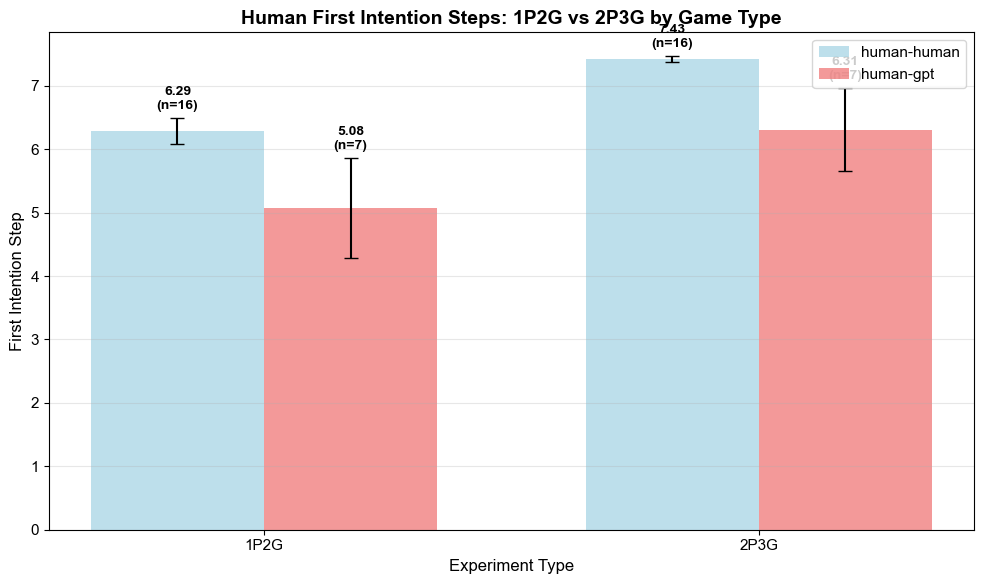

In [12]:
# Figure 1: First Intention Steps by Experiment Type and Game Type

# Calculate participant-level means
participant_means = plot_data.groupby(['participantID', 'experimentType', 'game_class'])['firstIntentionStep'].mean().reset_index()

# Prepare data for plotting
plot_summary = participant_means.groupby(['experimentType', 'game_class'])['firstIntentionStep'].agg(['mean', 'sem', 'count']).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create grouped bar plot
x_pos = np.arange(len(plot_summary['experimentType'].unique()))
width = 0.35

for i, game_type in enumerate(['human-human', 'human-gpt']):
    data = plot_summary[plot_summary['game_class'] == game_type]
    if len(data) > 0:
        means = data['mean'].values
        sems = data['sem'].values
        counts = data['count'].values

        bars = ax.bar(x_pos + i*width, means, width, yerr=sems,
                     label=f'{game_type.replace("-", "-")}', color=colors[game_type],
                     alpha=0.8, capsize=5)

        # Add value labels on bars
        for j, (bar, mean, sem, count) in enumerate(zip(bars, means, sems, counts)):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + sem + 0.1,
                   f'{mean:.2f}\n(n={count})', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Experiment Type')
ax.set_ylabel('First Intention Step')
ax.set_title('Human First Intention Steps: 1P2G vs 2P3G by Game Type', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos + width/2)
ax.set_xticklabels(plot_summary['experimentType'].unique())
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Statistical tests and annotations
print("Statistical Tests:")
for exp_type in ['1P2G', '2P3G']:
    exp_data = participant_means[participant_means['experimentType'] == exp_type]

    human_human_data = exp_data[exp_data['game_class'] == 'human-human']['firstIntentionStep'].dropna()
    human_gpt_data = exp_data[exp_data['game_class'] == 'human-gpt']['firstIntentionStep'].dropna()

    if len(human_human_data) > 0 and len(human_gpt_data) > 0:
        t_stat, p_value = stats.ttest_ind(human_human_data, human_gpt_data)
        pooled_std = np.sqrt(((len(human_human_data) - 1) * human_human_data.var() +
                             (len(human_gpt_data) - 1) * human_gpt_data.var()) /
                            (len(human_human_data) + len(human_gpt_data) - 2))
        cohens_d = (human_human_data.mean() - human_gpt_data.mean()) / pooled_std

        print(f"\n{exp_type}:")
        print(f"  Human-Human: n={len(human_human_data)}, mean={human_human_data.mean():.2f} ± {human_human_data.std():.2f}")
        print(f"  Human-GPT: n={len(human_gpt_data)}, mean={human_gpt_data.mean():.2f} ± {human_gpt_data.std():.2f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}, Cohen's d={cohens_d:.3f}")

plt.tight_layout()
plt.show()


## Figure 2: First Intention Steps Over Trials in 2P3G Games


\nTrend Analysis for 2P3G Games:
  human-human: slope = -0.1219, r² = 0.062, p = 0.000
  human-gpt: slope = -0.0652, r² = 0.004, p = 0.578


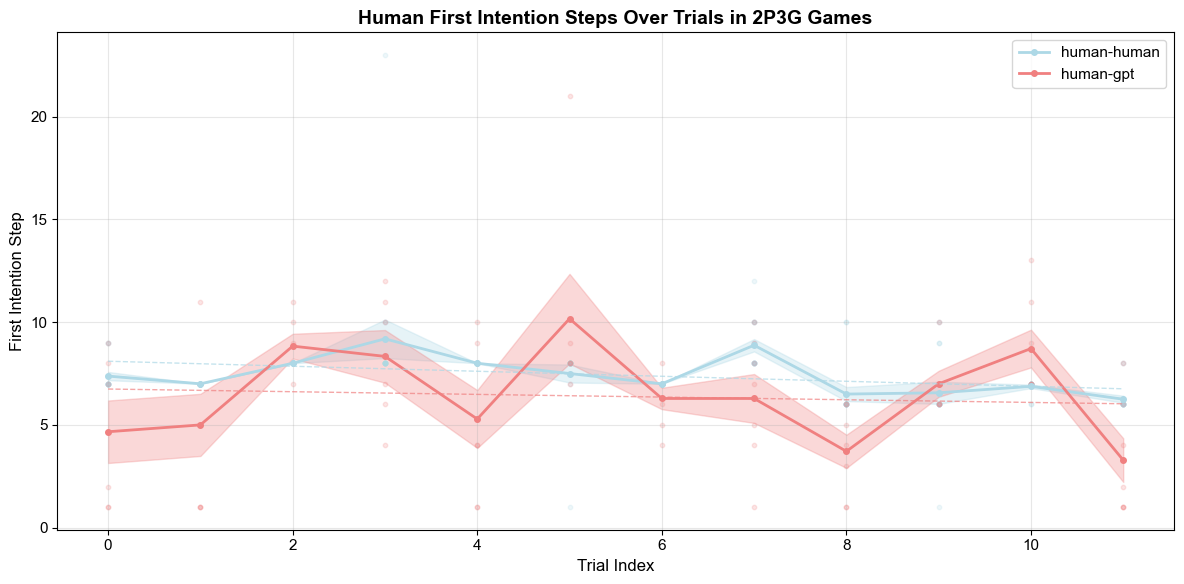

In [13]:
# Figure 2: First Intention Steps Over Trials in 2P3G Games

# Focus on 2P3G data
data_2p3g_analysis = plot_data[plot_data['experimentType'] == '2P3G'].copy()

if len(data_2p3g_analysis) > 0:
    # Create trial index if it doesn't exist (assuming trials are in order)
    if 'trialIndex' not in data_2p3g_analysis.columns:
        data_2p3g_indexed = data_2p3g_analysis.copy()
        data_2p3g_indexed['trialIndex'] = data_2p3g_indexed.groupby(['participantID', 'game_class']).cumcount() + 1
    else:
        data_2p3g_indexed = data_2p3g_analysis.copy()

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Line plot with confidence intervals
    for game_type in ['human-human', 'human-gpt']:
        data_subset = data_2p3g_indexed[data_2p3g_indexed['game_class'] == game_type]
        if len(data_subset) > 0:
            # Calculate means and confidence intervals by trial
            trial_summary = data_subset.groupby('trialIndex')['firstIntentionStep'].agg(['mean', 'sem', 'count']).reset_index()

            ax.plot(trial_summary['trialIndex'], trial_summary['mean'],
                   color=colors[game_type], marker='o', markersize=4, linewidth=2,
                   label=f'{game_type.replace("-", "-")}')

            # Add confidence intervals
            ax.fill_between(trial_summary['trialIndex'],
                           trial_summary['mean'] - trial_summary['sem'],
                           trial_summary['mean'] + trial_summary['sem'],
                           color=colors[game_type], alpha=0.3)

    # Scatter plot overlay for individual data points
    for game_type in ['human-human', 'human-gpt']:
        data_subset = data_2p3g_indexed[data_2p3g_indexed['game_class'] == game_type]
        if len(data_subset) > 0:
            ax.scatter(data_subset['trialIndex'], data_subset['firstIntentionStep'],
                      color=colors[game_type], alpha=0.2, s=10)

    ax.set_xlabel('Trial Index')
    ax.set_ylabel('First Intention Step')
    ax.set_title('Human First Intention Steps Over Trials in 2P3G Games', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add trend analysis
    print("\\nTrend Analysis for 2P3G Games:")
    for game_type in ['human-human', 'human-gpt']:
        subset = data_2p3g_indexed[data_2p3g_indexed['game_class'] == game_type]
        if len(subset) > 2:
            from scipy.stats import linregress
            slope, intercept, r_value, p_value, std_err = linregress(subset['trialIndex'], subset['firstIntentionStep'])
            print(f"  {game_type.replace('-', '-')}: slope = {slope:.4f}, r² = {r_value**2:.3f}, p = {p_value:.3f}")

            # Add trend line
            x_trend = np.array([subset['trialIndex'].min(), subset['trialIndex'].max()])
            y_trend = slope * x_trend + intercept
            ax.plot(x_trend, y_trend, color=colors[game_type], linestyle='--', alpha=0.7, linewidth=1)

    plt.tight_layout()
    plt.show()
else:
    print("No 2P3G data available for trial analysis")


## Figure 3: Distribution Comparison with Box Plots


\nDetailed Statistical Analysis:


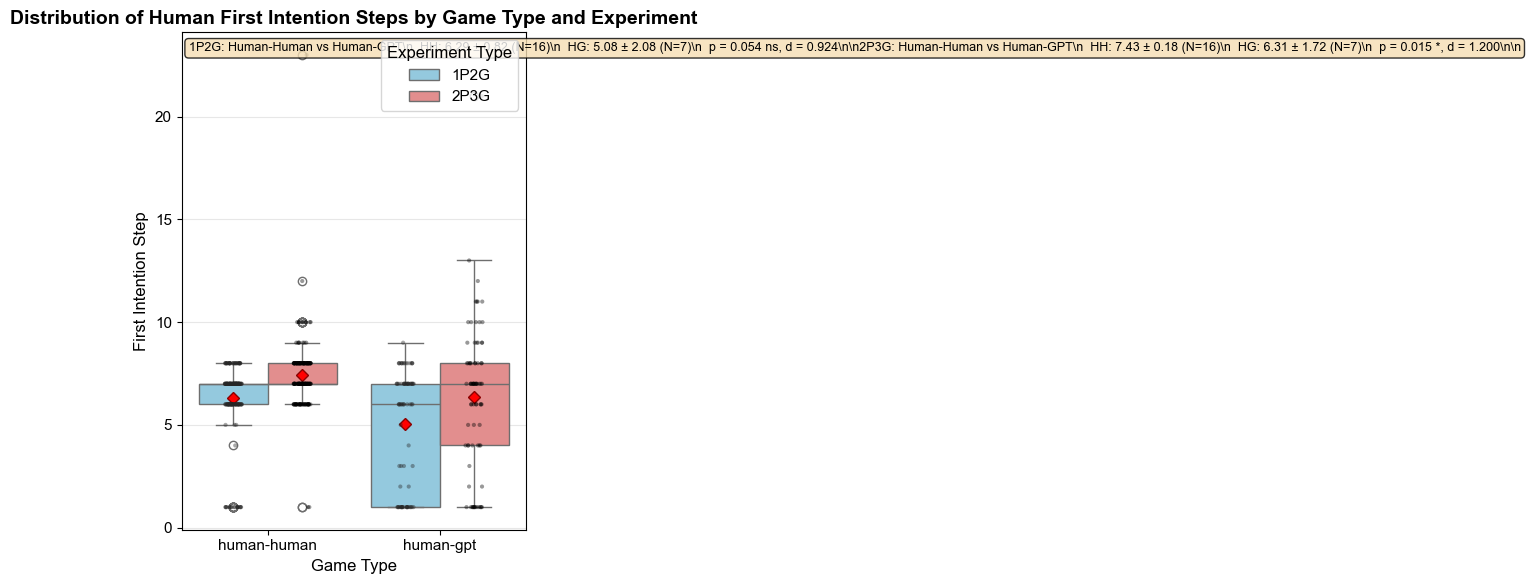

In [14]:
# Figure 3: Distribution Comparison with Box Plots

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create box plot with experiment type as hue
box_plot = sns.boxplot(data=plot_data, x='game_class', y='firstIntentionStep', hue='experimentType',
                      ax=ax, palette=['skyblue', 'lightcoral'],
                      showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

# Add strip plot for individual data points
sns.stripplot(data=plot_data, x='game_class', y='firstIntentionStep', hue='experimentType',
             ax=ax, size=3, alpha=0.4, dodge=True, color='black')

# Customize plot
ax.set_xlabel('Game Type')
ax.set_ylabel('First Intention Step')
ax.set_title('Distribution of Human First Intention Steps by Game Type and Experiment', fontsize=14, fontweight='bold')
ax.set_xticklabels([label.get_text().replace('-', '-') for label in ax.get_xticklabels()])
ax.grid(True, alpha=0.3, axis='y')

# Statistical analysis for each combination
print("\\nDetailed Statistical Analysis:")
combinations = []
for exp_type in ['1P2G', '2P3G']:
    exp_data = participant_means[participant_means['experimentType'] == exp_type]
    human_human_data = exp_data[exp_data['game_class'] == 'human-human']['firstIntentionStep']
    human_gpt_data = exp_data[exp_data['game_class'] == 'human-gpt']['firstIntentionStep']

    if len(human_human_data) > 0 and len(human_gpt_data) > 0:
        t_stat, p_value = stats.ttest_ind(human_human_data, human_gpt_data)
        pooled_std = np.sqrt(((len(human_human_data) - 1) * human_human_data.var() +
                             (len(human_gpt_data) - 1) * human_gpt_data.var()) /
                            (len(human_human_data) + len(human_gpt_data) - 2))
        cohens_d = (human_human_data.mean() - human_gpt_data.mean()) / pooled_std

        combinations.append({
            'exp_type': exp_type,
            'human_human_mean': human_human_data.mean(),
            'human_human_std': human_human_data.std(),
            'human_gpt_mean': human_gpt_data.mean(),
            'human_gpt_std': human_gpt_data.std(),
            'p_value': p_value,
            'cohens_d': cohens_d,
            'n_human_human': len(human_human_data),
            'n_human_gpt': len(human_gpt_data)
        })

# Add statistics text
textstr = ""
for combo in combinations:
    sig_text = "***" if combo['p_value'] < 0.001 else "**" if combo['p_value'] < 0.01 else "*" if combo['p_value'] < 0.05 else "ns"
    textstr += f"{combo['exp_type']}: Human-Human vs Human-GPT\\n"
    textstr += f"  HH: {combo['human_human_mean']:.2f} ± {combo['human_human_std']:.2f} (N={combo['n_human_human']})\\n"
    textstr += f"  HG: {combo['human_gpt_mean']:.2f} ± {combo['human_gpt_std']:.2f} (N={combo['n_human_gpt']})\\n"
    textstr += f"  p = {combo['p_value']:.3f} {sig_text}, d = {combo['cohens_d']:.3f}\\n\\n"

if textstr:
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Adjust legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Experiment Type', loc='upper right')

plt.tight_layout()
plt.show()


## Summary

This revised analysis properly handles player indices in human-gpt games:

1. **1P2G Analysis**: Uses player1's goal trajectory (human player)
2. **2P3G Analysis**: 
   - **Human-Human games**: Uses player1 as reference
   - **Human-GPT games**: Uses the correct human player's trajectory based on `humanPlayerIndex`
     - When `humanPlayerIndex = 0`: Uses `player1CurrentGoal` 
     - When `humanPlayerIndex = 1`: Uses `player2CurrentGoal`

This ensures that first intention step analysis accurately reflects human behavior regardless of player assignment in the experimental setup.


## Figure 4: First Intention Steps - Human vs GPT Comparison


\nFirst Intention Step Statistics by Condition:
  Human (Human-Human): n=192, mean=7.43 ± 1.69, median=7.0
  Human (Human-GPT): n=79, mean=6.38 ± 3.56, median=7.0
  GPT (Human-GPT): n=80, mean=7.36 ± 4.79, median=9.0
\nStatistical Comparisons:
  Human-Human vs Human-GPT (Human): t=3.282, p=0.001
  Human vs GPT (in Human-GPT games): t=-1.467, p=0.144
  Human-Human vs GPT: t=0.164, p=0.870
\nANOVA across all conditions: F=3.379, p=0.035


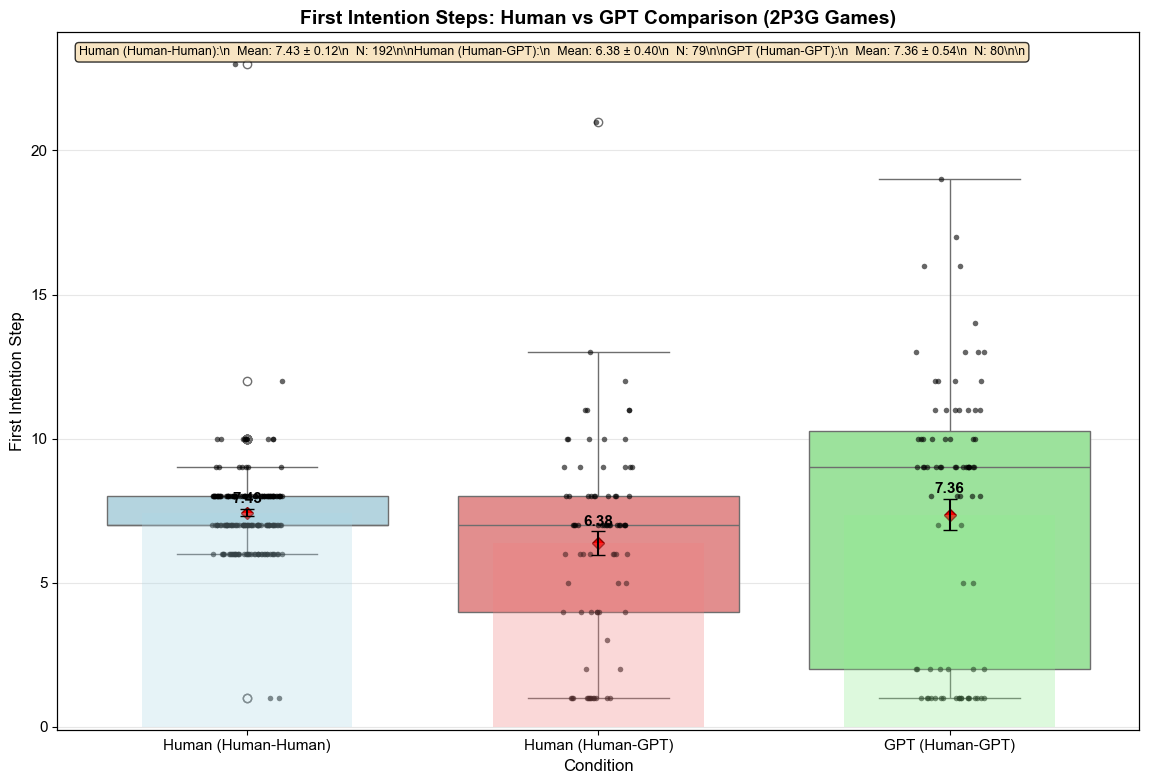

In [15]:
# Figure 4: First Intention Steps - Human vs GPT Comparison
# Plot showing: 1) Human in human-human, 2) Human in human-gpt, 3) GPT in human-gpt

# First, calculate GPT first intention steps for human-gpt games
def calculate_gpt_first_intention_step_2p3g(row):
    """Calculate first intention step for GPT player in 2P3G based on AI player index"""
    try:
        ai_index = row.get('aiPlayerIndex')

        if pd.isna(ai_index):
            return np.nan

        # Get AI player's goal data based on their index
        if ai_index == 0:
            goal_data = row['player1CurrentGoal']
        else:  # ai_index == 1
            goal_data = row['player2CurrentGoal']

        goal_list = safe_parse_goal_list(goal_data)
        if len(goal_list) == 0:
            return np.nan
        result = calculateFirstIntentionStep(goal_list)
        return result if result <= len(goal_list) else np.nan
    except:
        return np.nan

# Calculate GPT first intention steps for 2P3G human-gpt games
df_2p3g_human_gpt_analysis = df_2p3g[df_2p3g['game_class'] == 'human-gpt'].copy()
if len(df_2p3g_human_gpt_analysis) > 0:
    df_2p3g_human_gpt_analysis['gpt_firstIntentionStep'] = df_2p3g_human_gpt_analysis.apply(calculate_gpt_first_intention_step_2p3g, axis=1)

# Prepare data for the three conditions
conditions_data = []

# Focus on 2P3G data for fair comparison
plot_data_2p3g = plot_data[plot_data['experimentType'] == '2P3G'].copy()

# 1. Human in human-human games (2P3G)
human_human_data = plot_data_2p3g[plot_data_2p3g['game_class'] == 'human-human']['firstIntentionStep'].dropna()
if len(human_human_data) > 0:
    conditions_data.extend([('Human (Human-Human)', value) for value in human_human_data])

# 2. Human in human-gpt games (2P3G)
human_gpt_human_data = plot_data_2p3g[plot_data_2p3g['game_class'] == 'human-gpt']['firstIntentionStep'].dropna()
if len(human_gpt_human_data) > 0:
    conditions_data.extend([('Human (Human-GPT)', value) for value in human_gpt_human_data])

# 3. GPT in human-gpt games (2P3G)
if len(df_2p3g_human_gpt_analysis) > 0:
    gpt_data = df_2p3g_human_gpt_analysis['gpt_firstIntentionStep'].dropna()
    if len(gpt_data) > 0:
        conditions_data.extend([('GPT (Human-GPT)', value) for value in gpt_data])

# Convert to DataFrame for plotting
if conditions_data:
    comparison_df = pd.DataFrame(conditions_data, columns=['Condition', 'FirstIntentionStep'])

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Define colors for the three conditions
    condition_colors = {
        'Human (Human-Human)': 'lightblue',
        'Human (Human-GPT)': 'lightcoral',
        'GPT (Human-GPT)': 'lightgreen'
    }

    # Create box plot
    box_plot = sns.boxplot(data=comparison_df, x='Condition', y='FirstIntentionStep', ax=ax,
                          palette=[condition_colors[cond] for cond in comparison_df['Condition'].unique()],
                          showmeans=True, meanprops={'marker': 'D', 'markerfacecolor': 'red', 'markeredgecolor': 'darkred'})

    # Add strip plot for individual data points
    sns.stripplot(data=comparison_df, x='Condition', y='FirstIntentionStep', ax=ax,
                 size=4, alpha=0.6, color='black')

    # Customize plot
    ax.set_xlabel('Condition')
    ax.set_ylabel('First Intention Step')
    ax.set_title('First Intention Steps: Human vs GPT Comparison (2P3G Games)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Calculate statistics for each condition
    print("\\nFirst Intention Step Statistics by Condition:")
    stats_results = []

    for condition in comparison_df['Condition'].unique():
        data = comparison_df[comparison_df['Condition'] == condition]['FirstIntentionStep']
        stats_results.append({
            'condition': condition,
            'n': len(data),
            'mean': data.mean(),
            'std': data.std(),
            'median': data.median(),
            'sem': data.sem()
        })
        print(f"  {condition}: n={len(data)}, mean={data.mean():.2f} ± {data.std():.2f}, median={data.median():.1f}")

    # Add bar plot overlay with means and error bars
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())

    conditions = [stat['condition'] for stat in stats_results]
    means = [stat['mean'] for stat in stats_results]
    sems = [stat['sem'] for stat in stats_results]

    x_positions = range(len(conditions))
    bars = ax2.bar(x_positions, means, yerr=sems,
                   color=[condition_colors[cond] for cond in conditions],
                   alpha=0.3, capsize=5, width=0.6)

    # Add value labels on bars
    for i, (bar, mean, sem) in enumerate(zip(bars, means, sems)):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + sem + 0.1,
               f'{mean:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    ax2.set_ylabel('')
    ax2.set_yticks([])

    # Statistical comparisons
    print("\\nStatistical Comparisons:")

    # Human-Human vs Human-GPT (Human)
    hh_data = comparison_df[comparison_df['Condition'] == 'Human (Human-Human)']['FirstIntentionStep']
    hg_human_data = comparison_df[comparison_df['Condition'] == 'Human (Human-GPT)']['FirstIntentionStep']

    if len(hh_data) > 0 and len(hg_human_data) > 0:
        t_stat, p_value = stats.ttest_ind(hh_data, hg_human_data)
        print(f"  Human-Human vs Human-GPT (Human): t={t_stat:.3f}, p={p_value:.3f}")

    # Human vs GPT in Human-GPT games
    gpt_data_comparison = comparison_df[comparison_df['Condition'] == 'GPT (Human-GPT)']['FirstIntentionStep']

    if len(hg_human_data) > 0 and len(gpt_data_comparison) > 0:
        t_stat, p_value = stats.ttest_ind(hg_human_data, gpt_data_comparison)
        print(f"  Human vs GPT (in Human-GPT games): t={t_stat:.3f}, p={p_value:.3f}")

    # Human-Human vs GPT
    if len(hh_data) > 0 and len(gpt_data_comparison) > 0:
        t_stat, p_value = stats.ttest_ind(hh_data, gpt_data_comparison)
        print(f"  Human-Human vs GPT: t={t_stat:.3f}, p={p_value:.3f}")

    # ANOVA across all three conditions
    if len(stats_results) == 3:
        condition_groups = [
            comparison_df[comparison_df['Condition'] == cond]['FirstIntentionStep'].values
            for cond in comparison_df['Condition'].unique()
        ]
        f_stat, p_value = stats.f_oneway(*condition_groups)
        print(f"\\nANOVA across all conditions: F={f_stat:.3f}, p={p_value:.3f}")

    # Add statistics text box
    textstr = ""
    for stat in stats_results:
        textstr += f"{stat['condition']}:\\n"
        textstr += f"  Mean: {stat['mean']:.2f} ± {stat['sem']:.2f}\\n"
        textstr += f"  N: {stat['n']}\\n\\n"

    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

else:
    print("No data available for comparison")



First Intention Step Statistics by Condition:
  Human (Human-Human): n=192, mean=7.43 ± 1.69
  Human (Human-GPT): n=79, mean=6.38 ± 3.56
  GPT (Human-GPT): n=80, mean=7.36 ± 4.79

Statistical Comparisons:
  Human-Human vs Human-GPT (Human): t=3.282, p=0.001
  Human vs GPT (in Human-GPT games): t=-1.467, p=0.144
  Human-Human vs GPT: t=0.164, p=0.870

ANOVA across all conditions: F=3.379, p=0.035


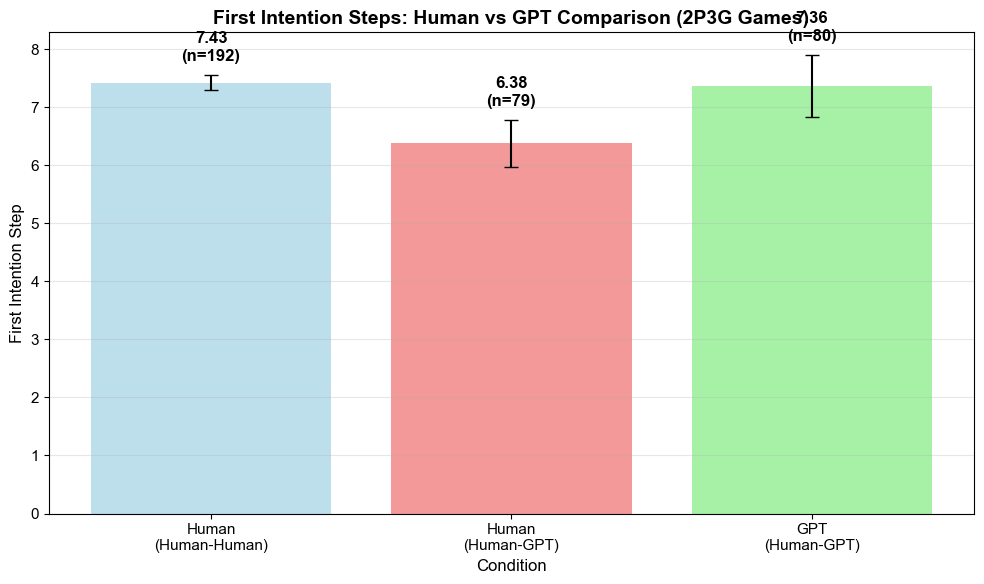

In [16]:
# Figure 4: Clean version - First Intention Steps Comparison
# Comparing: 1) Human in human-human, 2) Human in human-gpt, 3) GPT in human-gpt

# Calculate GPT first intention steps for human-gpt games
def calculate_gpt_first_intention_step_2p3g(row):
    """Calculate first intention step for GPT player in 2P3G based on AI player index"""
    try:
        ai_index = row.get('aiPlayerIndex')

        if pd.isna(ai_index):
            return np.nan

        # Get AI player's goal data based on their index
        if ai_index == 0:
            goal_data = row['player1CurrentGoal']
        else:  # ai_index == 1
            goal_data = row['player2CurrentGoal']

        goal_list = safe_parse_goal_list(goal_data)
        if len(goal_list) == 0:
            return np.nan
        result = calculateFirstIntentionStep(goal_list)
        return result if result <= len(goal_list) else np.nan
    except:
        return np.nan

# Calculate GPT first intention steps for 2P3G human-gpt games
df_2p3g_human_gpt_analysis = df_2p3g[df_2p3g['game_class'] == 'human-gpt'].copy()
if len(df_2p3g_human_gpt_analysis) > 0:
    df_2p3g_human_gpt_analysis['gpt_firstIntentionStep'] = df_2p3g_human_gpt_analysis.apply(calculate_gpt_first_intention_step_2p3g, axis=1)

# Create the comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Focus on 2P3G data for fair comparison
plot_data_2p3g = plot_data[plot_data['experimentType'] == '2P3G'].copy()

# Prepare data for each condition
condition_data = {}

# 1. Human in human-human games (2P3G)
human_human_data = plot_data_2p3g[plot_data_2p3g['game_class'] == 'human-human']['firstIntentionStep'].dropna()
if len(human_human_data) > 0:
    condition_data['Human\n(Human-Human)'] = human_human_data

# 2. Human in human-gpt games (2P3G)
human_gpt_human_data = plot_data_2p3g[plot_data_2p3g['game_class'] == 'human-gpt']['firstIntentionStep'].dropna()
if len(human_gpt_human_data) > 0:
    condition_data['Human\n(Human-GPT)'] = human_gpt_human_data

# 3. GPT in human-gpt games (2P3G)
if len(df_2p3g_human_gpt_analysis) > 0:
    gpt_data = df_2p3g_human_gpt_analysis['gpt_firstIntentionStep'].dropna()
    if len(gpt_data) > 0:
        condition_data['GPT\n(Human-GPT)'] = gpt_data

if condition_data:
    # Define colors
    colors_list = ['lightblue', 'lightcoral', 'lightgreen']

    # Calculate statistics and create bar plot
    conditions = list(condition_data.keys())
    means = [condition_data[cond].mean() for cond in conditions]
    sems = [condition_data[cond].sem() for cond in conditions]
    counts = [len(condition_data[cond]) for cond in conditions]

    # Create bar plot
    bars = ax.bar(range(len(conditions)), means, yerr=sems,
                  color=colors_list[:len(conditions)], alpha=0.8, capsize=5)

    # Add value labels on bars
    for i, (bar, mean, sem, count) in enumerate(zip(bars, means, sems, counts)):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + sem + 0.2,
               f'{mean:.2f}\n(n={count})', ha='center', va='bottom', fontweight='bold')

    # Customize plot
    ax.set_xlabel('Condition')
    ax.set_ylabel('First Intention Step')
    ax.set_title('First Intention Steps: Human vs GPT Comparison (2P3G Games)', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(conditions)))
    ax.set_xticklabels(conditions)
    ax.grid(True, alpha=0.3, axis='y')

    # Statistical analysis
    print("\nFirst Intention Step Statistics by Condition:")
    for i, condition in enumerate(conditions):
        data = condition_data[condition]
        print(f"  {condition.replace(chr(10), ' ')}: n={len(data)}, mean={data.mean():.2f} ± {data.std():.2f}")

    # Pairwise statistical comparisons
    print("\nStatistical Comparisons:")
    if len(conditions) >= 2:
        # Human-Human vs Human-GPT (Human)
        if 'Human\n(Human-Human)' in condition_data and 'Human\n(Human-GPT)' in condition_data:
            hh_data = condition_data['Human\n(Human-Human)']
            hg_human_data = condition_data['Human\n(Human-GPT)']
            t_stat, p_value = stats.ttest_ind(hh_data, hg_human_data)
            print(f"  Human-Human vs Human-GPT (Human): t={t_stat:.3f}, p={p_value:.3f}")

        # Human vs GPT in Human-GPT games
        if 'Human\n(Human-GPT)' in condition_data and 'GPT\n(Human-GPT)' in condition_data:
            hg_human_data = condition_data['Human\n(Human-GPT)']
            gpt_data = condition_data['GPT\n(Human-GPT)']
            t_stat, p_value = stats.ttest_ind(hg_human_data, gpt_data)
            print(f"  Human vs GPT (in Human-GPT games): t={t_stat:.3f}, p={p_value:.3f}")

        # Human-Human vs GPT
        if 'Human\n(Human-Human)' in condition_data and 'GPT\n(Human-GPT)' in condition_data:
            hh_data = condition_data['Human\n(Human-Human)']
            gpt_data = condition_data['GPT\n(Human-GPT)']
            t_stat, p_value = stats.ttest_ind(hh_data, gpt_data)
            print(f"  Human-Human vs GPT: t={t_stat:.3f}, p={p_value:.3f}")

    # ANOVA across all conditions
    if len(conditions) >= 3:
        condition_groups = [condition_data[cond].values for cond in conditions]
        f_stat, p_value = stats.f_oneway(*condition_groups)
        print(f"\nANOVA across all conditions: F={f_stat:.3f}, p={p_value:.3f}")

    plt.tight_layout()
    plt.show()

else:
    print("No data available for comparison")
